Device set to use mps:0


Average inference time over 5 runs: 0.333s ± 0.236s


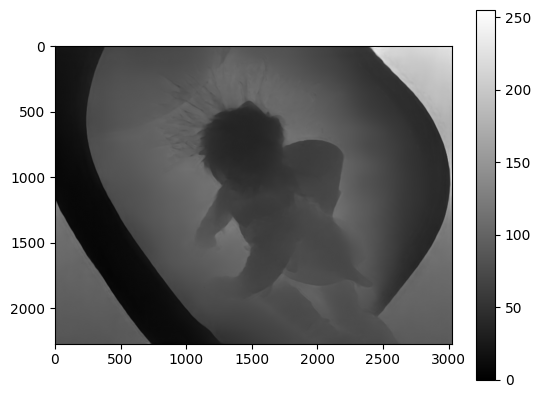

In [2]:

import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"

from transformers import pipeline
from PIL import Image
import matplotlib.pyplot as plt

pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Metric-Indoor-Small-hf")
image_path = '/Users/jchunx/code/k1/ml-depth-pro/data/example.jpg'
image = Image.open(image_path)

import time
import numpy as np

# Profile the pipeline
num_runs = 5
times = []

for _ in range(num_runs):
    start = time.time()
    _ = pipe(image)
    end = time.time()
    times.append(end - start)

avg_time = np.mean(times)
std_time = np.std(times)

print(f"Average inference time over {num_runs} runs: {avg_time:.3f}s ± {std_time:.3f}s")

depth = pipe(image)["depth"] # pil image
depth_array = np.array(depth)
# visualize the depth map with reference axis
plt.imshow(depth_array, cmap='gray')
plt.colorbar()
plt.show()



In [1]:
from PIL import Image
import depth_pro
from depth_pro.depth_pro import *
import matplotlib.pyplot as plt

/opt/miniconda3/envs/sapiens/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
image_path = '/Users/jchunx/code/k1/ml-depth-pro/data/example.jpg'

# Load model and preprocessing transform
print("loading model..")
DEFAULT_MONODEPTH_CONFIG_DICT.checkpoint_uri = "/Users/jchunx/code/k1/ml-depth-pro/checkpoints/depth_pro.pt"

model, transform = depth_pro.create_model_and_transforms(DEFAULT_MONODEPTH_CONFIG_DICT, device=torch.device("mps"), precision=torch.float16)
model.eval()


loading model..


/Users/jchunx/code/k1/ml-depth-pro/src/depth_pro/depth_pro.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(config.checkpoint_uri, map_location=

DepthPro(
  (encoder): DepthProEncoder(
    (patch_encoder): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linea

In [17]:
# Load and preprocess an image.
image, _, f_px = depth_pro.load_rgb(image_path)
image = transform(image)

# Run inference.
prediction = model.infer(image, f_px=f_px)
depth = prediction["depth"]  # Depth in [m].
focallength_px = prediction["focallength_px"]  # Focal length in pixels.

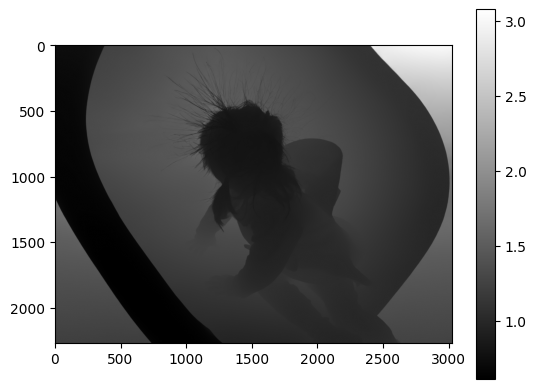

In [19]:
# Plot the depth map
depth = depth.cpu().numpy()
plt.imshow(depth, cmap='gray')
plt.colorbar()
plt.show()

In [25]:
import time
import numpy as np

# Benchmark inference speed
num_iters = 2
times = []

print(f"Running {num_iters} iterations...")
for i in range(num_iters):
    print(f"Iteration {i+1} of {num_iters}")
    start = time.time()
    # Run inference
    image, _, f_px = depth_pro.load_rgb(image_path)
    print("image loaded")
    image = transform(image)
    print("image transformed")
    prediction = model.infer(image, f_px=f_px)
    print("inference done")
    end = time.time()
    times.append(end - start)

times = np.array(times)
mean_time = np.mean(times)
std_time = np.std(times)
iters_per_sec = 1.0 / mean_time

print(f"\nResults:")
print(f"Average time per iteration: {mean_time:.3f}s ± {std_time:.3f}s")
print(f"Iterations per second: {iters_per_sec:.2f}")


Running 2 iterations...
Iteration 1 of 2
image loaded
image transformed
inference done
Iteration 2 of 2
image loaded
image transformed
inference done

Results:
Average time per iteration: 8.772s ± 1.260s
Iterations per second: 0.11
